<a href="https://colab.research.google.com/github/profedaniel86/Series_de_Tiempo/blob/main/5.%20VAR/VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentos de analítica 2 -Aprendizaje Automatico III (clase 5)

## Diego Fernando Agudelo - Daniel Felipe Osorio
## Universidad ICESI
## diegoagudelo30@gmail.com - dfosorio@icesi.edu.co

## **1. Carga de paquetes**

In [1]:
!pip install bayesian-optimization

In [2]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

from statsmodels.stats.diagnostic import het_arch

from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
#from statsmodels.tsa.vector_ar.var_model import VARSelect

from sklearn.model_selection import TimeSeriesSplit

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/5.%20VAR/data.csv")
data.head()

,y1,y2
0,0.292764,0.354733
1,-0.284374,0.126277
2,0.343942,-1.057280
3,0.675844,-0.397178
4,-0.326084,-0.374396


(202, 2)


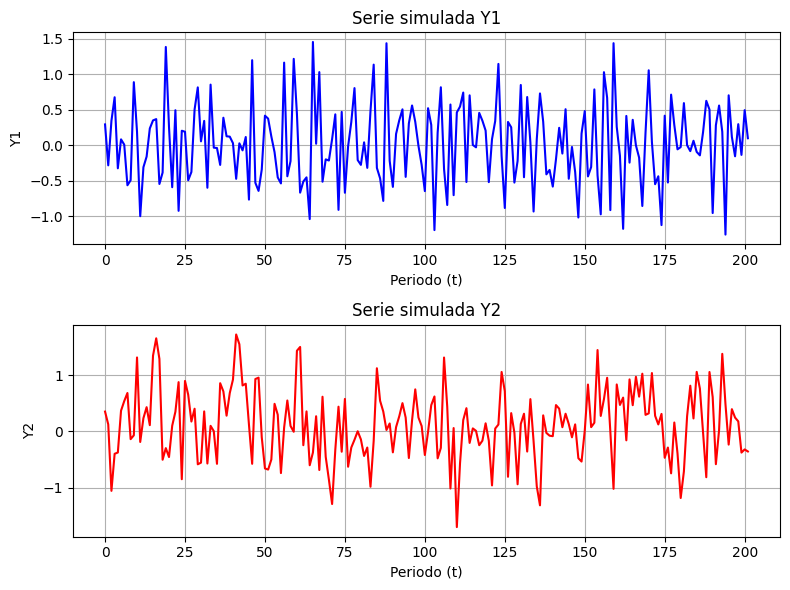

In [4]:
# imprimiendo el tamano del dataframe
print(data.shape)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Primer gráfico para la serie y1
ax1.set_title("Serie simulada Y1")
ax1.set_xlabel("Periodo (t)")
ax1.set_ylabel("Y1")
ax1.plot(data[["y1"]], color='blue')
ax1.grid()

# Segundo gráfico para la serie y2
ax2.set_title("Serie simulada Y2")
ax2.set_xlabel("Periodo (t)")
ax2.set_ylabel("Y2")
ax2.plot(data[["y2"]], color='red')
ax2.grid()

# Ajustar espaciado entre los subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

## **3. Seleccionar el orden del modelo VAR**

In [5]:
model = VAR(data)
result = model.select_order()
result.summary()

,AIC,BIC,FPE,HQIC
0,-2.080,-2.046,0.1249,-2.066
1,-2.631,-2.528*,0.07201,-2.589*
2,-2.634,-2.462,0.07180,-2.564
3,-2.635*,-2.394,0.07174*,-2.537
4,-2.616,-2.306,0.07310,-2.491
5,-2.604,-2.225,0.07402,-2.450
6,-2.570,-2.122,0.07660,-2.388
7,-2.556,-2.040,0.07766,-2.347
8,-2.552,-1.967,0.07799,-2.315
9,-2.560,-1.905,0.07745,-2.294


## **4. Estimación del modelo**

In [6]:
model = VAR(data)
results = model.fit(3,trend="c")# trend =  c , ct ,ctt, n
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Nov, 2025
Time:                     20:26:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.42066
Nobs:                     199.000    HQIC:                  -2.55858
Log likelihood:          -286.829    FPE:                  0.0704894
AIC:                     -2.65235    Det(Omega_mle):       0.0657802
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.063875         0.037217            1.716           0.086
L1.y1        -0.312904         0.070723           -4.424           0.000
L1.y2        -0.407944         0.068671           -5.941           0.000
L2.y1        -0.096474

<Axes: >

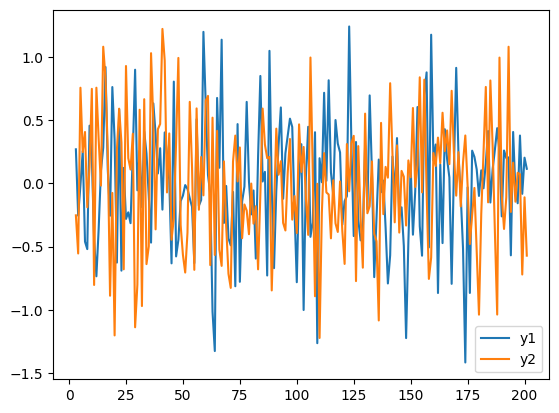

In [7]:
results.resid.plot()

In [8]:
lag_order = results.k_ar
lag_order

3

In [9]:
lag_order = results.k_ar
results.forecast_interval (data.values[-lag_order:], 5)

(array([[ 0.09598223, -0.1188748 ],
        [-0.05909522,  0.04683363],
        [ 0.00421677,  0.01923556],
        [ 0.04258693,  0.07236612],
        [ 0.03466075,  0.10631863]]),
 array([[-0.87572797, -1.13342969],
        [-1.15413887, -1.19053282],
        [-1.11695695, -1.21828551],
        [-1.0864726 , -1.1708847 ],
        [-1.10025315, -1.14175439]]),
 array([[1.06769242, 0.89568008],
        [1.03594842, 1.28420008],
        [1.12539049, 1.25675663],
        [1.17164646, 1.31561694],
        [1.16957466, 1.35439164]]))

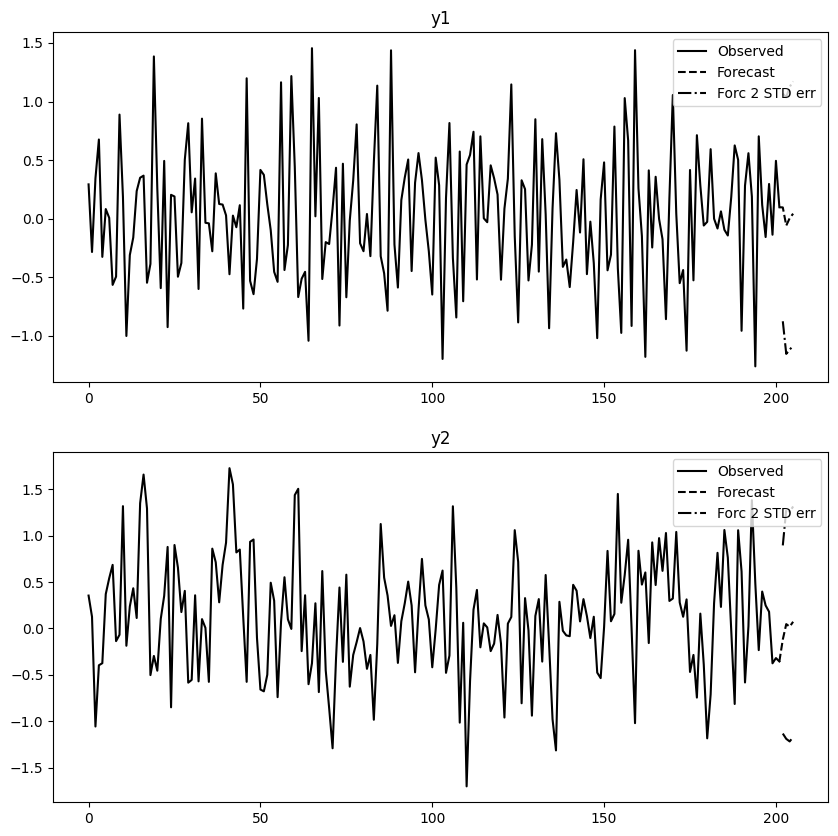

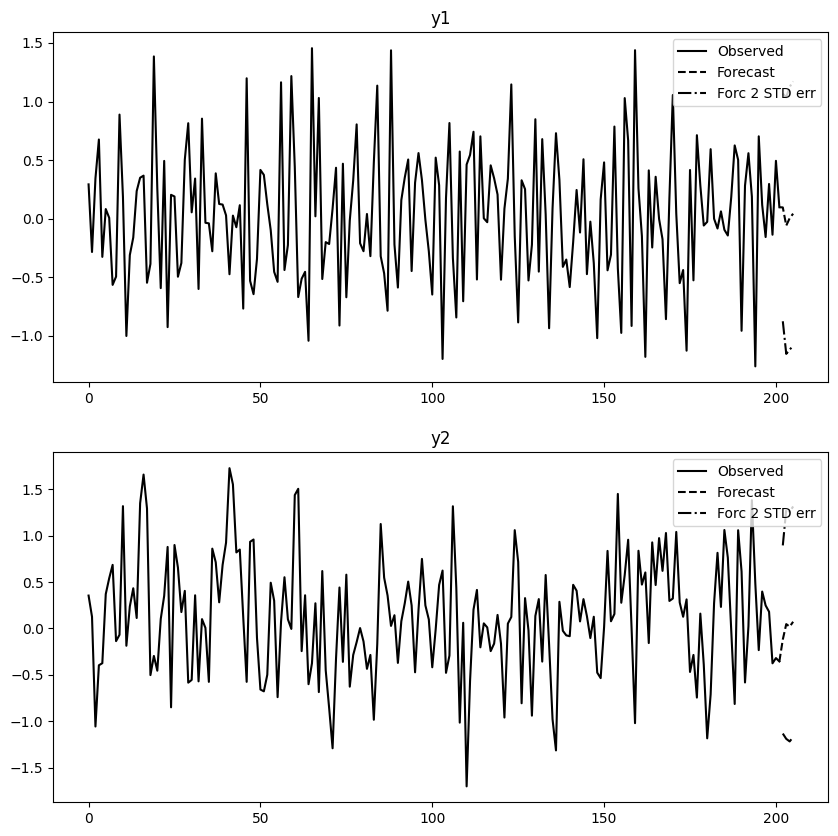

In [10]:
results.plot_forecast(4)

## **5. Causalidad a Granger**

Es un test consistente en comprobar si los resultados de una variable sirven para predecir a otra variable, si tiene carácter unidireccional o bidireccional. Para ello se tiene que comparar y deducir si el comportamiento actual y el pasado de una serie temporal A predice la conducta de una serie temporal B. Si ocurre el hecho, se dice que “el resultado A” causa en el sentido de Wiener-Granger “el resultado B”; el comportamiento es unidireccional. Si sucede lo explicado e igualmente “el resultado B” predice “el resultado A”, el comportamiento es bidireccional, entonces “el resultado A” causa “el resultado B”, y “el resultado B” causa “el resultado A”.

In [11]:
causa = results.test_causality('y2', ['y1'], kind='f')
causa.summary()

Test statistic,Critical value,p-value,df
24.08,2.628,0.000,"(3, 384)"


## **5. Autocorrelación**
$H{0}: ρ = 0$ (Es decir no hay autocorrelación)

$H{1}: ρ \not= 0$ (Es decir hay autocorrelación)

In [12]:
d=results.test_whiteness(4,adjusted =True )
d.summary()

Test statistic,Critical value,p-value,df
4.470,9.488,0.346,4


In [13]:
lag_pvalue = {}
lag_conclusion = {}
lag_conclusion1 = {}
for lag in range(4, 16):
    p_values = results.test_whiteness(lag,adjusted =False)
    lag_pvalue[lag] = p_values.pvalue
    lag_conclusion[lag] = p_values.conclusion
    lag_conclusion1[lag] = p_values.conclusion_str
df_results = pd.DataFrame({'p_value': lag_pvalue, 'conclusion': lag_conclusion1})

df_results["Conclusión_espanol"] = np.where(df_results['p_value']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
df_results

,p_value,conclusion,Conclusión_espanol
4,0.355465,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
5,0.551610,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
6,0.685234,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
7,0.498653,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
8,0.216006,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
9,0.282111,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
10,0.416752,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
11,0.489551,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
12,0.612582,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr
13,0.646160,Conclusion: fail to reject H_0,no_rechazo_ho/no_hay_autocorr


In [14]:
df_results.index.name = "lag"
df_results.reset_index(inplace=True)

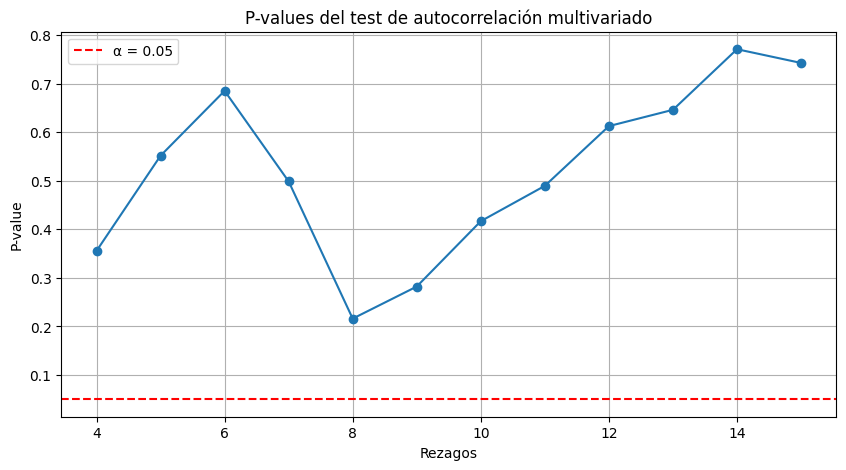

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_results["lag"], df_results["p_value"], marker='o')
plt.axhline(y=0.05, color='r', linestyle='--', label="α = 0.05")
plt.title("P-values del test de autocorrelación multivariado")
plt.xlabel("Rezagos")
plt.ylabel("P-value")
plt.legend()
plt.grid(True)
plt.show()

### **6. Normalidad**

In [16]:
d1 = results.test_normality()
d1.summary()

Test statistic,Critical value,p-value,df
2.356,9.488,0.671,4


## **8. Prueba de estacionariedad(raices unitarias)**

$H{0}: la serie de tiempo tiene raíz unitaria.

$H{1}: la serie de tiempo no tiene raíz unitaria.

In [17]:
from statsmodels.tsa.stattools import adfuller

dk1 = adfuller(data["y1"])
print('ADF Statistic: %f' % dk1[0])
print('p-value: %f' % dk1[1])
print('Critical Values:')
for key, value in dk1[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.071784
p-value: 0.000016
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


## **9. Ejercicio en Clase**

Empleando la información las variables 'realgdp', 'realcons' y 'realinv' ajuste un modelo VAR y genere 5 pronósticos para cada variable.

In [18]:

import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)

In [19]:
mdata

,realgdp,realcons,realinv
1959-03-31,2710.349,1707.4,286.898
1959-06-30,2778.801,1733.7,310.859
1959-09-30,2775.488,1751.8,289.226
1959-12-31,2785.204,1753.7,299.356
1960-03-31,2847.699,1770.5,331.722
...,...,...,...
2008-09-30,13324.600,9267.7,1990.693
2008-12-31,13141.920,9195.3,1857.661
2009-03-31,12925.410,9209.2,1558.494
2009-06-30,12901.504,9189.0,1456.678


## **10. Parcial final**

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
- La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de junio a las 23:59  para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

### El Problema

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde junio de 2014.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos